In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
def import_metrics_json(models_path, run_num):
    """
    Looks in {models_path}/{run_num}/metrics.json and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(models_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

In [3]:
def get_best_metric(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value to use for
    comparison. The best metric value is determined by `metric_compare_func`, which
    must take in two arguments, and return whether or not the _first_ one is better.
    Returns the number of the run, the value associated with that run, and a dict of
    all the values used for comparison.
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_val, all_vals = None, None, {}
    for run_num in metrics.keys():
        try:
            val = reduce_func(metrics[run_num][metric_name]["values"])
            all_vals[run_num] = val
            if best_val is None or compare_func(val, best_val):
                best_val, best_run = val, run_num
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_val, all_vals

In [4]:
def get_best_metric_at_best_epoch(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value FOR EACH
    SUBARRAY/VALUE in the value array to use for comparison. The best metric value
    is determined by `metric_compare_func`, which must take in two arguments, and
    return whether or not the _first_ one is better.
    Returns the number of the run, the (one-indexed) number of the epch, the value
    associated with that run and epoch, and a dict of all the values used for
    comparison (mapping pair of run number and epoch number to value).
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_epoch, best_val, all_vals = None, None, None, {}
    for run_num in metrics.keys():
        try:
            # Find the best epoch within that run
            best_epoch_in_run, best_val_in_run = None, None
            for i, subarr in enumerate(metrics[run_num][metric_name]["values"]):
                val = reduce_func(subarr)
                if best_val_in_run is None or compare_func(val, best_val_in_run):
                    best_epoch_in_run, best_val_in_run = i + 1, val
            all_vals[(run_num, best_epoch_in_run)] = best_val_in_run
            
            # If the best value in the best epoch of the run is best so far, update
            if best_val is None or compare_func(best_val_in_run, best_val):
                best_run, best_epoch, best_val = run_num, best_epoch_in_run, best_val_in_run
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_epoch, best_val, all_vals

In [5]:
def print_validation_profile_and_prior_losses(condition):
    models_path = "/users/amtseng/att_priors/models/trained_models/profile_models/%s/" % condition
    
    print("Best profile loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_prof_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.2f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["train_prof_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["val_prof_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.4f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)]))
    return all_vals

In [12]:
noprior_vals = print_validation_profile_and_prior_losses("HepG2")

Best profile loss overall:
	Best run: 4
	Best epoch in run: 10
	Associated value: 179.99440738677978
Best epoch in each run:
	Run 1, epoch 10: 180.97
	Run 2, epoch 8: 180.73
	Run 3, epoch 7: 180.46
	Run 4, epoch 10: 179.99
	Run 5, epoch 10: 180.05
	Run 6, epoch 10: 180.81
	Run 7, epoch 8: 181.37
All validation profile and prior losses:
1
	200.36 194.65 193.33 192.59 192.15 191.83 191.66 191.52 191.40 191.25
	184.69 182.63 181.86 181.45 181.32 181.37 181.15 181.13 181.09 180.97
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
2
	199.41 194.43 193.20 192.45 192.04 191.73 191.50 191.35 191.22 191.14
	184.60 182.48 181.70 181.30 180.91 180.93 180.88 180.73 180.80 180.90
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
3
	198.70 193.95 192.49 191.83 191.42 191.19 191.02 190.83 190.75 190.59
	183.93 181.95 181.27 180.81 180.70 180.67 180.46 180.62 180.62 180.83
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
4
	199.55 194.49 

In [14]:
prior_vals = print_validation_profile_and_prior_losses("HepG2_prior")

Best profile loss overall:
	Best run: 3
	Best epoch in run: 7
	Associated value: 181.0568891398112
Best epoch in each run:
	Run 1, epoch 9: 181.77
	Run 2, epoch 9: 181.86
	Run 3, epoch 7: 181.06
	Run 4, epoch 10: 181.13
	Run 5, epoch 9: 181.66
	Run 6, epoch 6: 182.12
All validation profile and prior losses:
1
	199.37 194.95 194.05 193.47 193.14 192.86 192.67 192.56 192.45 192.38
	184.64 183.46 182.80 182.50 182.20 182.05 182.10 182.17 181.77 182.11
	0.1124 0.0946 0.0776 0.0777 0.0766 0.0789 0.0812 0.0818 0.0797 0.0826
2
	199.63 195.21 194.34 193.89 193.69 193.50 193.34 193.15 193.09 192.99
	184.50 183.09 183.09 182.21 182.38 182.05 182.14 182.13 181.86 181.90
	0.1013 0.0823 0.0744 0.0758 0.0762 0.0742 0.0755 0.0810 0.0776 0.0781
3
	199.85 195.26 194.04 193.39 193.00 192.85 192.69 192.56 192.47 192.40
	184.08 182.69 182.14 181.53 181.53 181.49 181.06 181.22 181.28 181.22
	0.0980 0.0929 0.0930 0.0843 0.0784 0.0846 0.0813 0.0852 0.0845 0.0822
4
	199.82 195.20 194.24 193.80 193.51 193.30 1

In [9]:
def print_validation_and_prior_losses(condition):
    models_path = "/users/amtseng/att_priors/models/trained_models/binary_models/%s/" % condition
    
    print("Best validation loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.3f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["train_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["val_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)]))
    return all_vals

In [33]:
noprior_vals = print_validation_and_prior_losses("HepG2_keep1")

Best validation loss overall:
	Best run: 6
	Best epoch in run: 4
	Associated value: 0.36000752200682956
Best epoch in each run:
	Run 1, epoch 5:  0.393
	Run 2, epoch 4:  0.371
	Run 3, epoch 2:  0.393
	Run 4, epoch 3:  0.373
	Run 5, epoch 3:  0.405
	Run 6, epoch 4:  0.360
	Run 7, epoch 4:  0.363
	Run 8, epoch 3:  0.364
	Run 9, epoch 4:  0.366
	Run 10, epoch 6:  0.403
All validation profile and prior losses:
1
	 0.501  0.386  0.337  0.307  0.266  0.228  0.192  0.172  0.144  0.130
	 0.439  0.400  0.400  0.396  0.393  0.426  0.463  0.509  0.506  0.530
	 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
2
	 0.481  0.390  0.341  0.304  0.260  0.225  0.196  0.172  0.152  0.137
	 0.423  0.383  0.389  0.371  0.393  0.417  0.452  0.459  0.449  0.516
	 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
3
	 0.483  0.381  0.338  0.290  0.249  0.210  0.190  0.163  0.142  0.125
	 0.448  0.393  0.409  0.402  0.424  0.447  0.478  0.496  0.501  0.542
	 0.000  0.000  

In [34]:
prior_vals = print_validation_and_prior_losses("HepG2_prior_keep1")

Best validation loss overall:
	Best run: 9
	Best epoch in run: 8
	Associated value: 0.35352155566215515
Best epoch in each run:
	Run 1, epoch 10:  0.371
	Run 2, epoch 10:  0.368
	Run 3, epoch 6:  0.384
	Run 4, epoch 8:  0.371
	Run 5, epoch 4:  0.369
	Run 6, epoch 10:  0.379
	Run 7, epoch 9:  0.374
	Run 8, epoch 7:  0.384
	Run 9, epoch 8:  0.354
	Run 10, epoch 5:  0.388
All validation profile and prior losses:
1
	 0.515  0.434  0.392  0.365  0.346  0.324  0.305  0.368  0.342  0.314
	 0.498  0.429  0.427  0.387  0.390  0.391  0.382  0.402  0.391  0.371
	 0.111  0.064  0.093  0.076  0.090  0.089  0.096  0.132  0.104  0.106
2
	 0.493  0.435  0.387  0.365  0.353  0.331  0.318  0.312  0.307  0.298
	 0.486  0.429  0.402  0.416  0.388  0.386  0.374  0.377  0.394  0.368
	 0.111  0.080  0.064  0.132  0.099  0.070  0.092  0.099  0.106  0.134
3
	 0.517  0.432  0.388  0.365  0.342  0.323  0.300  0.346  0.352  0.327
	 0.472  0.439  0.392  0.399  0.386  0.384  0.400  0.408  0.401  0.415
	 0.103  0.10

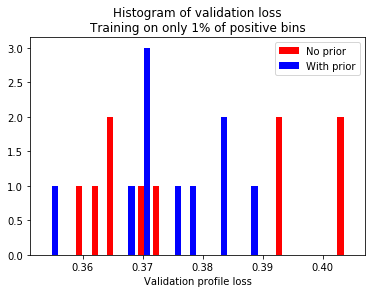

In [35]:
bin_num = 20
plt.figure()
plt.hist(
    [np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"])
title = "Histogram of validation loss"
title += "\nTraining on only 1% of positive bins"
plt.title(title)
plt.xlabel("Validation profile loss")
plt.legend()

In [36]:
np_vals, p_vals = np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))
t, p = scipy.stats.ttest_ind(np_vals, p_vals)
print(t)
print(p / 2)

0.7637576384837572
0.2274535370283432
